In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, BatchNormalization, LeakyReLU, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
import time
import os
import mlflow
import mlflow.tensorflow
import joblib

### Load Processed Data

In [2]:
data = joblib.load(r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\final_dataOG.pkl")

In [3]:
print(data.dtypes)
print(data.shape)
print(data.head())

Image_path          object
Cost_of_vehicle    float64
Min_coverage       float64
Expiry_date        float64
Max_coverage       float64
                    ...   
2043               float32
2044               float32
2045               float32
2046               float32
2047               float32
Length: 2066, dtype: object
(1310, 2066)
                            Image_path  Cost_of_vehicle  Min_coverage  \
0  images/train_images/img_4513976.jpg         0.453657      0.453657   
1  images/train_images/img_7764995.jpg         1.485276      1.485276   
2   images/train_images/img_451308.jpg         1.350717      1.350717   
3  images/train_images/img_7768372.jpg        -0.443403     -0.443403   
4  images/train_images/img_7765274.jpg        -1.104984     -1.104984   

   Expiry_date  Max_coverage  Condition    Amount  Insurance_company_A  \
0     0.694979      3.477133          0 -3.251022                  0.0   
1     0.036866      0.210875          1  0.541665                  0.0   
2

In [4]:
# Extract structured data (already encoded & scaled)
# Extract first 18 columns, excluding columns 1, 6, and 7
structured_data = data.iloc[:, :18]  # First 18 columns
structured_data = structured_data.drop(columns=[data.columns[0], data.columns[5], data.columns[6]])
structured_data_scaled = structured_data.values


In [5]:
# Extract image features
image_features = data.iloc[:, 18:].values

In [6]:
print(structured_data.columns)
print(data.columns)

Index(['Cost_of_vehicle', 'Min_coverage', 'Expiry_date', 'Max_coverage',
       'Insurance_company_A', 'Insurance_company_AA', 'Insurance_company_AC',
       'Insurance_company_B', 'Insurance_company_BB', 'Insurance_company_BC',
       'Insurance_company_BQ', 'Insurance_company_C', 'Insurance_company_DA',
       'Insurance_company_O', 'Insurance_company_RE'],
      dtype='object')
Index([          'Image_path',      'Cost_of_vehicle',         'Min_coverage',
                'Expiry_date',         'Max_coverage',            'Condition',
                     'Amount',  'Insurance_company_A', 'Insurance_company_AA',
       'Insurance_company_AC',
       ...
                         2038,                   2039,                   2040,
                         2041,                   2042,                   2043,
                         2044,                   2045,                   2046,
                         2047],
      dtype='object', length=2066)


In [7]:
image_features.shape

(1310, 2048)

In [8]:
# Extract labels
condition_labels = data['Condition'].values  # Binary classification target
amount_labels = data['Amount'].values.reshape(-1, 1)  # Regression target

In [9]:
# Check for NaNs before training
assert not np.any(pd.isna(condition_labels)), "Condition labels contain NaNs!"
assert not np.any(pd.isna(amount_labels)), "Amount labels contain NaNs!"


In [10]:
print(np.isnan(image_features).sum(), np.isnan(structured_data_scaled).sum())

0 0


### Build Model

In [11]:
#Image Feature Branch
image_input = Input(shape=(image_features.shape[1],), name='image_input')
x = Dense(2048, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(image_input)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x)

x = Dense(1024, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x)

x = Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x)

In [12]:
#Structured Data Branch
structured_input = Input(shape=(structured_data_scaled.shape[1],), name='structured_input')
y = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(structured_input)
y = BatchNormalization()(y)
y = LeakyReLU(negative_slope=0.1)(y)
y = Dropout(0.2)(y)

y = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(y)
y = BatchNormalization()(y)
y = LeakyReLU(negative_slope=0.1)(y)
y = Dropout(0.2)(y)


In [13]:
combined = Concatenate()([x, y])

z = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(combined)
z = BatchNormalization()(z)
z = LeakyReLU(negative_slope=0.1)(z)
z = Dropout(0.2)(z)

z = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(z)
z = BatchNormalization()(z)
z = LeakyReLU(negative_slope=0.1)(z)
z = Dropout(0.2)(z)




In [14]:
# Output 1: Condition (Binary Classification)
condition_output = Dense(1, activation='sigmoid', name='condition_output')(z)

In [15]:
# Output 2: Amount (Regression)
amount_output = Dense(1, activation='linear', name='amount_output')(z)

In [16]:
# Define the Model
model = Model(inputs=[image_input, structured_input], outputs=[condition_output, amount_output])

In [17]:
# CosineDecay for Adaptive Learning Rate
lr_schedule = CosineDecay(initial_learning_rate=0.001, decay_steps=1000, alpha=0.0001)

In [18]:
# from tensorflow.keras.saving import register_keras_serializable

# @register_keras_serializable()
# def weighted_huber_loss(y_true, y_pred):
#     delta = 5000  # Adjust as needed
#     weights = 1 + (y_true / tf.reduce_max(y_true))  # Higher weight for high claims
#     huber = tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
#     return tf.reduce_mean(huber * weights)

In [19]:
# Compile the Model
# Loss Weights to balance binary classification and regression loss
#loss_weights = {'condition_output': 1.0, 'amount_output': 0.1}

model.compile(optimizer=Adam(learning_rate=lr_schedule, clipnorm=1.0),
              loss={'condition_output': 'binary_crossentropy', 'amount_output':tf.keras.losses.Huber(delta=5000.0)},
              metrics={'condition_output': AUC(), 'amount_output':'mae'}  # Or another suitable metric
)

In [20]:
#callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
best_model_path = r'C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\best_model.keras'

checkpoint = ModelCheckpoint(
    best_model_path,
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model (based on validation loss)
    mode='min',  # We want to minimize the validation loss
    verbose=1
)


### Train Model

In [21]:
print(condition_labels.shape, amount_labels.shape)

(1310,) (1310, 1)


In [22]:
# Print the model summary
#model.summary()

In [23]:
# Ensure model directory exists
model_dir = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models"
os.makedirs(model_dir, exist_ok=True)

In [24]:
# Generate unique model filename
timestamp = int(time.time())
model_path = os.path.join(model_dir, f"model_{timestamp}.keras")


In [25]:
# Set up MLflow Tracking
#mlflow.set_tracking_uri("file:C:/Users/varsh/OneDrive/Desktop/notebook/Fast_Furious_Insured/python notebooks/mlruns")

In [26]:
from tensorflow.keras.models import load_model
import numpy as np

# Start MLflow Tracking
with mlflow.start_run():
    mlflow.log_param('learning_rate', 0.001)
    mlflow.log_param('epochs', 200)
    mlflow.log_param('batch_size', 32)

    history = model.fit(
        [image_features, structured_data_scaled],
        {'condition_output': condition_labels, 'amount_output': amount_labels},
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint],  # ModelCheckpoint ensures best model is saved
        verbose=1
    )

    # Log all metrics dynamically
    for key in history.history.keys():
        mlflow.log_metric(key, history.history[key][-1])

    # ✅ Load Best Model Before Saving & Logging
    best_model = load_model(best_model_path)  # Load the best model

    # ✅ Save & Log Best Model
    best_model.save(model_path, include_optimizer=True)
    print(f"Best trained model saved and logged in MLflow at {model_path}")


Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - amount_output_loss: 0.9094 - amount_output_mae: 0.9764 - condition_output_auc: 0.7291 - condition_output_loss: 0.5485 - loss: 9.0056 
Epoch 1: val_loss improved from inf to 5.89680, saving model to C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - amount_output_loss: 0.9005 - amount_output_mae: 0.9719 - condition_output_auc: 0.7336 - condition_output_loss: 0.5443 - loss: 8.9723 - val_amount_output_loss: 0.2291 - val_amount_output_mae: 0.5305 - val_condition_output_auc: 1.0000 - val_condition_output_loss: 0.1322 - val_loss: 5.8968
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - amount_output_loss: 0.3680 - amount_output_mae: 0.6523 - condition_output_auc: 0.9823 - condition_output_loss: 0.1351 - loss: 5.6908
Epoch 2: val_loss improved from 5.89680 to 4.56346, saving model to C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\mod

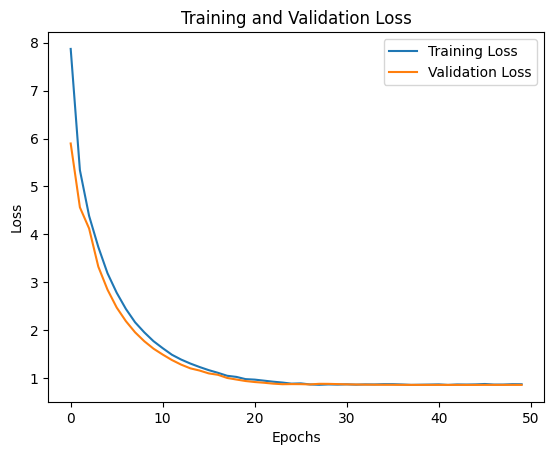

In [27]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [28]:
# Print Final Training & Validation Metrics
print("Final Training and Validation Metrics:")

for metric, values in history.history.items():
    print(f"{metric}: {values[-1]:.4f}")  # Print last value for each metric

Final Training and Validation Metrics:
amount_output_loss: 0.0949
amount_output_mae: 0.3232
condition_output_auc: 1.0000
condition_output_loss: 0.0070
loss: 0.8693
val_amount_output_loss: 0.0898
val_amount_output_mae: 0.2884
val_condition_output_auc: 1.0000
val_condition_output_loss: 0.0019
val_loss: 0.8560


In [29]:
import os
import json

# Paths
MODEL_DIR = r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models"
BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_model.keras")
MODEL_METADATA_PATH = os.path.join(MODEL_DIR, "models_metadata.json")

val_loss = min(history.history["val_loss"])

# Ensure model directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Create metadata file
metadata = {BEST_MODEL_PATH: val_loss}

# Save metadata
with open(MODEL_METADATA_PATH, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Metadata file created at {MODEL_METADATA_PATH} with validation loss: {val_loss}")


Metadata file created at C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\models_metadata.json with validation loss: 0.8553240299224854


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Get predicted claim amounts
_, amount_preds = model.predict([image_features, structured_data_scaled])

# Evaluate
mae = mean_absolute_error(amount_labels, amount_preds)
mse = mean_squared_error(amount_labels, amount_preds)
rmse = np.sqrt(mse)
r2 = r2_score(amount_labels, amount_preds)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step  
MAE: 0.20
MSE: 0.09
RMSE: 0.29
R² Score: 0.9145


In [31]:
print("amount_labels shape:", amount_labels.shape)
print("amount_preds shape:", amount_preds.shape)

amount_labels shape: (1310, 1)
amount_preds shape: (1310, 1)


In [32]:
residuals = amount_labels.flatten() - amount_preds.flatten()


In [33]:
print("Residuals shape:", residuals.shape)

Residuals shape: (1310,)


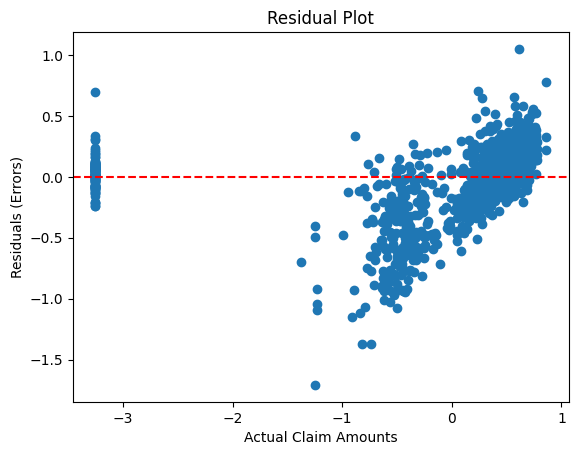

In [34]:
plt.scatter(amount_labels.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Claim Amounts")
plt.ylabel("Residuals (Errors)")
plt.title("Residual Plot")
plt.show()


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Filter data where Condition = 1
idx = condition_labels == 1  # Assuming `condition_labels` is your Condition column
true_claims = amount_labels[idx]
pred_claims = amount_preds[idx]

# Compute metrics
mae = mean_absolute_error(true_claims, pred_claims)
rmse = np.sqrt(mean_squared_error(true_claims, pred_claims))
r2 = r2_score(true_claims, pred_claims)

print(f"MAE: {mae}, RMSE: {rmse}, R²: {r2}")


MAE: 0.20970540630886103, RMSE: 0.301522785595398, R²: 0.45623550181446537


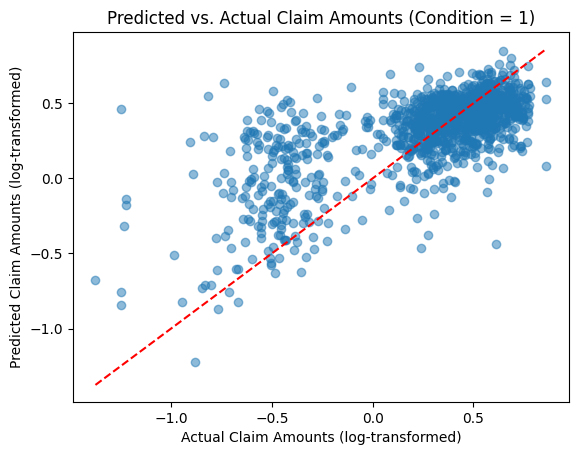

In [36]:
import matplotlib.pyplot as plt

plt.scatter(true_claims, pred_claims, alpha=0.5)
plt.plot([min(true_claims), max(true_claims)], [min(true_claims), max(true_claims)], 'r--')  # Perfect fit line
plt.xlabel("Actual Claim Amounts (log-transformed)")
plt.ylabel("Predicted Claim Amounts (log-transformed)")
plt.title("Predicted vs. Actual Claim Amounts (Condition = 1)")
plt.show()
